In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/archive_2.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/sad/Training_65242339.jpg  
  inflating: /content/data/train/sad/Training_65267116.jpg  
  inflating: /content/data/train/sad/Training_65275626.jpg  
  inflating: /content/data/train/sad/Training_6529266.jpg  
  inflating: /content/data/train/sad/Training_65329617.jpg  
  inflating: /content/data/train/sad/Training_65338712.jpg  
  inflating: /content/data/train/sad/Training_65338797.jpg  
  inflating: /content/data/train/sad/Training_65387162.jpg  
  inflating: /content/data/train/sad/Training_65404494.jpg  
  inflating: /content/data/train/sad/Training_65426218.jpg  
  inflating: /content/data/train/sad/Training_65430136.jpg  
  inflating: /content/data/train/sad/Training_65437377.jpg  
  inflating: /content/data/train/sad/Training_6545735.jpg  
  inflating: /content/data/train/sad/Training_65463385.jpg  
  inflating: /content/data/train/sad/Training_65473985.jpg  
  inflating: /content/data/train/sad

In [3]:
# import required packages
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from keras import layers

In [19]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255,width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,shear_range=0.2,zoom_range=0.3)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/data/train',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/data/test',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [21]:
base_model = VGG16(input_shape = (48, 48, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False


# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(7, activation='softmax')(x)

model1 = tf.keras.models.Model(base_model.input, x)

model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [22]:
vgg_model = model1.fit(train_generator, validation_data = validation_generator, epochs = 30)

Epoch 1/60
449/449 [==============================] - 38s 82ms/step - loss: 1.8032 - accuracy: 0.2781 - val_loss: 1.7015 - val_accuracy: 0.3210
Epoch 2/60
449/449 [==============================] - 36s 81ms/step - loss: 1.7461 - accuracy: 0.2842 - val_loss: 1.6686 - val_accuracy: 0.3396
Epoch 3/60
449/449 [==============================] - 37s 81ms/step - loss: 1.7418 - accuracy: 0.2942 - val_loss: 1.6481 - val_accuracy: 0.3459
Epoch 4/60
449/449 [==============================] - 38s 84ms/step - loss: 1.7382 - accuracy: 0.2926 - val_loss: 1.6850 - val_accuracy: 0.3254
Epoch 5/60
449/449 [==============================] - 36s 81ms/step - loss: 1.7380 - accuracy: 0.2976 - val_loss: 1.6503 - val_accuracy: 0.3454
Epoch 6/60
449/449 [==============================] - 36s 80ms/step - loss: 1.7357 - accuracy: 0.2978 - val_loss: 1.6647 - val_accuracy: 0.3151
Epoch 7/60
449/449 [==============================] - 36s 80ms/step - loss: 1.7358 - accuracy: 0.2991 - val_loss: 1.6462 - val_accuracy:

KeyboardInterrupt: ignored

In [8]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    plt.style.use('dark_background')
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

<ipython-input-8-37e2b4767761>:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-8-37e2b4767761>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


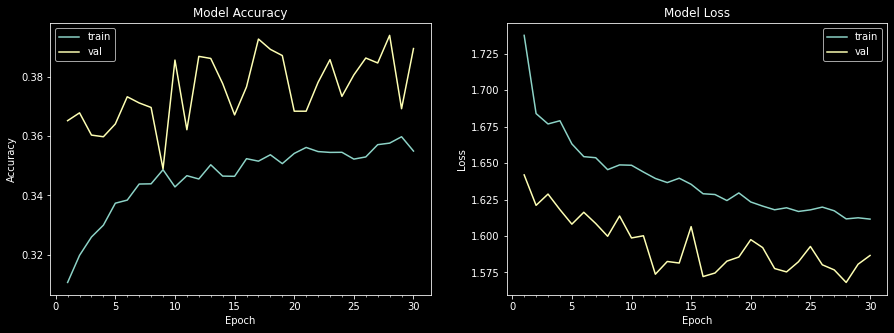

In [9]:
plot_model_history(vgg_model)

In [10]:
tr_predictions = model1.predict(train_generator)

449/449 [==============================] - 11s 23ms/step


-----------------------------------------------------------------
[[  96    0   92 1997  541  920  349]
 [  10    0   14  202   58  112   40]
 [  96    0   97 1994  562  955  393]
 [ 160    0  181 3632  946 1641  655]
 [ 110    0  100 2470  673 1153  459]
 [ 130    0  114 2362  612 1153  459]
 [  62    0   76 1538  428  766  301]]


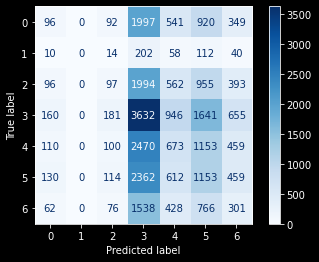

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.14      0.02      0.04      3995
           1       0.00      0.00      0.00       436
           2       0.14      0.02      0.04      4097
           3       0.26      0.50      0.34      7215
           4       0.18      0.14      0.15      4965
           5       0.17      0.24      0.20      4830
           6       0.11      0.09      0.10      3171

    accuracy                           0.21     28709
   macro avg       0.14      0.15      0.13     28709
weighted avg       0.18      0.21      0.17     28709



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [11]:
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(train_generator.classes, tr_predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(train_generator.classes, tr_predictions.argmax(axis=1)))
clf_report = classification_report(train_generator.classes, tr_predictions.argmax(axis=1),output_dict=True)

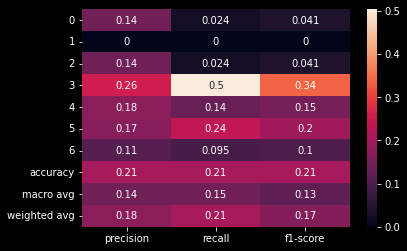

In [12]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [13]:
# do prediction on test data
predictions = model1.predict(validation_generator)

113/113 [==============================] - 3s 23ms/step


-----------------------------------------------------------------
[[ 23   0  20 464 146 214  91]
 [  2   0   2  53  19  23  12]
 [ 14   0  24 493 142 256  95]
 [ 47   0  53 893 228 391 162]
 [ 36   0  35 577 167 304 114]
 [ 38   0  38 634 148 270 119]
 [ 15   0  22 438  95 192  69]]


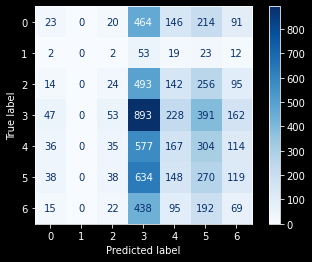

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.13      0.02      0.04       958
           1       0.00      0.00      0.00       111
           2       0.12      0.02      0.04      1024
           3       0.25      0.50      0.34      1774
           4       0.18      0.14      0.15      1233
           5       0.16      0.22      0.19      1247
           6       0.10      0.08      0.09       831

    accuracy                           0.20      7178
   macro avg       0.14      0.14      0.12      7178
weighted avg       0.17      0.20      0.16      7178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [14]:
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(validation_generator.classes, predictions.argmax(axis=1)))
clf_report1 = classification_report(validation_generator.classes, predictions.argmax(axis=1),output_dict=True)

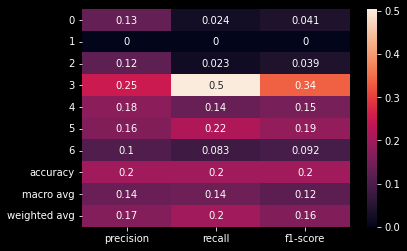

In [15]:
sns.heatmap(pd.DataFrame(clf_report1).iloc[:-1, :].T, annot=True)

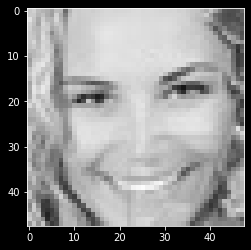

In [24]:
img = load_img("/content/data/test/happy/PrivateTest_10077120.jpg",target_size = (48,48))
img = np.array(img)
plt.imshow(img)

In [17]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,3)
result = model1.predict(img)
result = list(result[0])
print(result)
img_index = result.index(max(result))
print(emotion_dict[img_index])

1/1 [==============================] - 0s 330ms/step
[0.45190886, 1.2189769e-30, 5.294725e-25, 2.3687805e-31, 0.38864356, 0.1594476, 0.0]
Angry


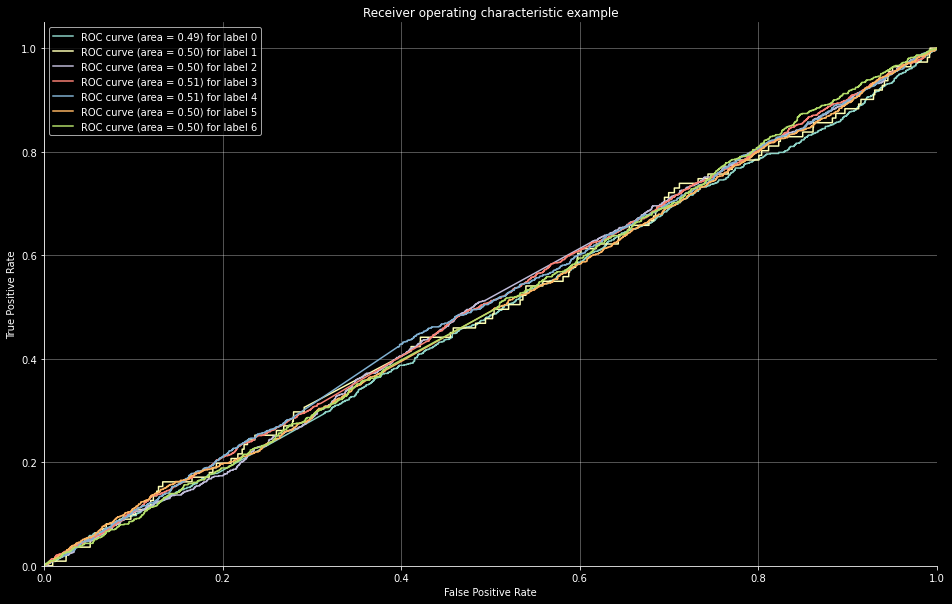

In [18]:
def plot_multiclass_roc( prediction, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(predictions, validation_generator.classes, n_classes=7, figsize=(16, 10))